<a href="https://colab.research.google.com/github/AAP9002/Third-Year-Project/blob/main/_polished_solutions/Classification_Models/VARIENT_class_bend_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Left and Right Bend Video Classification with a 3D convolutional neural network

Original code from: https://www.tensorflow.org/tutorials/video/video_classification

Adapted for bend classification - original code was for action recognition

In [2]:
# VARIENT = "Optic_flow_narrow"
# VARIENT = "Optic_flow_wide"
# VARIENT = "RGB_narrow"
VARIENT = "RGB_wide"


if "RGB" in VARIENT:
  MODE = "RGB"
else:
  MODE = "OPTIC_FLOW"

CHANNELS = 3 # OR SET TO 2

NUMBER_OF_CLASSES = 7 #3,4,7

## Setup

Begin by installing and importing some necessary libraries, including:
[tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [3]:
!pip install tqdm opencv-python einops --quiet
!pip install -U tensorflow keras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [4]:
import tqdm
import random
import pathlib
import itertools
import collections
import zipfile
import os

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [5]:
RANDOM_SEED = 42 # for dataset slip and SMOTE reproducability
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [6]:
DATASET = "RGB_OF_LARGE"

DATASET_FILE = f"{DATASET}.zip"

In [7]:
from huggingface_hub import snapshot_download

# set HF_TOKEN in your enviroment
snapshot_download(repo_id="aap9002/RGB_Optic_Flow_Bend_Classification",  repo_type="dataset", allow_patterns=f"*{DATASET_FILE}", local_dir='./')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

RGB_OF_LARGE.zip:   0%|          | 0.00/1.80G [00:00<?, ?B/s]

'/content'

## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from our custom dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [8]:
def list_files_per_class(local_zip_file):
    """
    List the files in each class of the dataset from a local zip file.

    Args:
      local_zip_file: Path to the local zip file.

    Returns:
      A dictionary mapping each class to a list of file names belonging to that class.
    """
    files_by_class = {}
    with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
        for zip_info in zip_ref.infolist():
            # Skip directories.
            if not zip_info.is_dir():
                filename = zip_info.filename
                if not filename.endswith('.avi'):
                  continue
                class_name = get_class(filename)  # Assumes get_class is defined elsewhere.
                if class_name is None: # skip if no class name retuened
                  continue

                if class_name not in files_by_class:
                    files_by_class[class_name] = []
                files_by_class[class_name].append(filename)

    print(f"Found {len(files_by_class)} classes.")
    for cls, files in files_by_class.items():
        print(f"{cls}: {len(files)} files")
    return files_by_class

def get_class(fname, MAX_DISTANCE_ALLOWED = 50, MIN_SPEED_ALLOWED = 15):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  if VARIENT not in fname:
    return None

  angle = fname.split('_')[-4]

  distance = fname.split('_')[-3]

  speed = fname.split('_')[-5]

  if int(distance) > MAX_DISTANCE_ALLOWED:
    return None

  if float(speed) < MIN_SPEED_ALLOWED:
    return None

  # print(f"Angle: {angle}, Distance: {distance}, Speed: {speed}"

  streight = 1
  light = 5
  moderate = 10

  angle = float(angle)

  if abs(angle) <= streight:
    class_name = 'streight'
  elif int(angle) < 0:
    if NUMBER_OF_CLASSES == 3:
      return 'left'
    if abs(int(angle)) < light:
      class_name = 'light_left'
      if NUMBER_OF_CLASSES == 4:
        return None
    elif abs(int(angle)) < moderate:
      class_name = 'moderate_left'
    else:
      class_name = 'sharp_left'
  else:
    if NUMBER_OF_CLASSES == 3:
      return 'right'
    if int(angle) < light:
      class_name = 'light_right'
      if NUMBER_OF_CLASSES == 4:
        return None
    elif int(angle) < moderate:
      class_name = 'moderate_right'
    else:
      class_name = 'sharp_right'

  return class_name

def unzip_from_local_zip(local_zip_file, to_dir, file_names=None):
    """
    Extract selected files (if file_names is provided) or all files from a local zip file into the given directory,
    flattening the directory structure.

    Args:
      local_zip_file: Path to the local zip file.
      to_dir: Directory where the files will be extracted.
      file_names: Optional list of file names to extract. If None, all files are extracted.
    """
    with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
        if file_names is None:
            file_infos = [info for info in zip_ref.infolist() if not info.is_dir()]
        else:
            file_infos = []
            for fn in file_names:
                try:
                    info = zip_ref.getinfo(fn)
                    file_infos.append(info)
                except KeyError:
                    print(f"Warning: {fn} not found in the zip file.")
        for info in tqdm.tqdm(file_infos, desc="Extracting files"):
            fn = info.filename
            # Determine the class name for the file (assumes get_class is defined)
            class_name = get_class(fn)
            target_dir = to_dir / class_name
            target_dir.mkdir(parents=True, exist_ok=True)

            # Extract the file to the target directory.
            zip_ref.extract(info, path=str(target_dir))

            # The extracted file may include subdirectories; flatten it.
            extracted_file = target_dir / fn
            file_basename = pathlib.Path(fn).name
            output_file = target_dir / file_basename

            if extracted_file != output_file:
                extracted_file.rename(output_file)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def parse_subset(zip_path, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """

  files_for_class = list_files_per_class(zip_path)

  classes = list(files_for_class.keys())

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    rng = random.Random(RANDOM_SEED + hash(cls))  # seed per class for determinism
    rng.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)}

  dirs = {}

  for split_name in splits:
        split_dir = download_dir / split_name
        split_files = []
        for cls in classes:
            total = len(files_for_class[cls])
            # Compute counts based on percentages.
            train_count = int(round(total * splits.get("train", 0)))
            val_count = int(round(total * splits.get("val", 0)))
            # For test, we take the remaining files.
            test_count = total - train_count - val_count

            if split_name == "train":
                selected = files_for_class[cls][:train_count]
            elif split_name == "val":
                selected = files_for_class[cls][train_count:train_count + val_count]
            elif split_name == "test":
                selected = files_for_class[cls][train_count + val_count:]
            else:
                raise ValueError(f"Unknown split name: {split_name}")
            split_files.extend(selected)
        print(f"{split_name}: extracting {len(split_files)} files")
        unzip_from_local_zip(zip_path, split_dir, file_names=split_files)
        dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  if CHANNELS == 2:
    # remove last channel since all zeros
    frame = frame[..., :CHANNELS]
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 2):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()

  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()

  if not MODE == "OPTIC_FLOW":
    result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      rng = random.Random(RANDOM_SEED)
      rng.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [9]:
download_dir = pathlib.Path('./left_right_subset/')

subset_paths = parse_subset(DATASET_FILE,
                        splits = {"train": 0.7, "val": 0.2, "test": 0.1},
                        download_dir = download_dir)

Found 7 classes.
sharp_right: 164 files
sharp_left: 173 files
moderate_left: 388 files
light_right: 406 files
light_left: 349 files
streight: 409 files
moderate_right: 349 files
train: extracting 1566 files


Extracting files: 100%|██████████| 1566/1566 [00:03<00:00, 510.64it/s]


val: extracting 449 files


Extracting files: 100%|██████████| 449/449 [00:00<00:00, 504.51it/s]


test: extracting 223 files


Extracting files: 100%|██████████| 223/223 [00:00<00:00, 493.99it/s]


Split Distribution

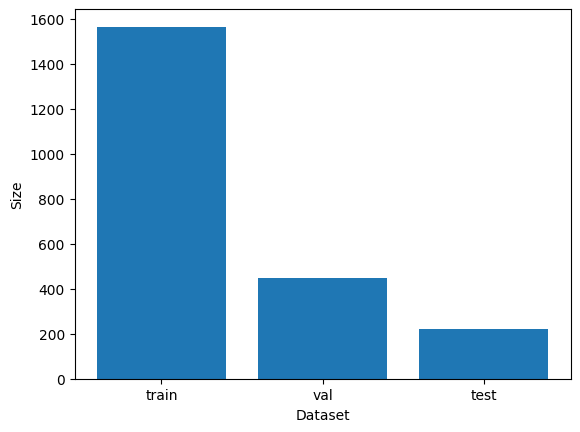

In [10]:
def get_dataset_size(set):
  return len(list(subset_paths[set].glob('*/*.avi')))

sets = ['train', 'val', 'test']

plt.bar(x = range(len(sets)), height = [get_dataset_size(s) for s in sets])
plt.xlabel('Dataset')
plt.ylabel('Size')
plt.xticks(range(len(sets)), sets)
plt.show()


Class Distribution

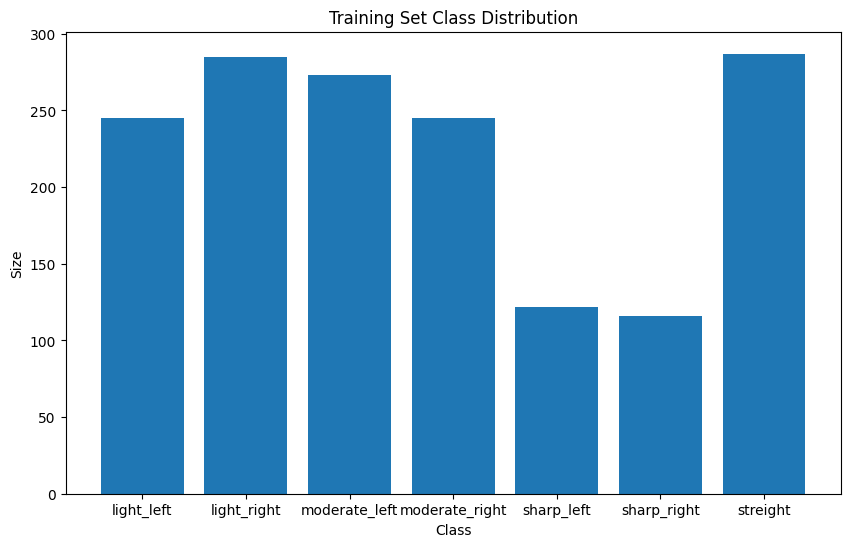

In [11]:
def count_class_size(class_name):
  return len(list(subset_paths['train'].glob(f'{class_name}/*')))

fg = FrameGenerator(subset_paths['train'], 1, training=True)
labels = list(fg.class_ids_for_name.keys())

plt.figure(figsize=(10, 6))
plt.title('Training Set Class Distribution')
plt.bar(x = range(len(labels)), height = [count_class_size(c) for c in labels])
plt.xlabel('Class')
plt.ylabel('Size')
plt.xticks(range(len(labels)), labels)
plt.show()

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [12]:
n_frames = 10
batch_size = 32

output_signature = (tf.TensorSpec(shape = (None, None, None, CHANNELS), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)

# # Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)


In [13]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Assuming train_ds is your original training dataset
# Extract all data from the dataset into NumPy arrays
X_list, y_list = [], []
for frames, label in train_ds.unbatch().as_numpy_iterator():
    X_list.append(frames)
    y_list.append(label)

X_train = np.array(X_list)
y_train = np.array(y_list)

# Example: Suppose each sample has shape (n_frames, height, width, channels)
n_samples, n_frames, height, width, channels = X_train.shape

# Flatten each sample to a 1D vector:
X_train_flat = X_train.reshape(n_samples, -1)

# 2) figure out your “pivot” size = the second-largest class count
counts = Counter(y_train)
# sorted counts in descending order
sorted_counts = sorted(counts.values(), reverse=True)
pivot = sorted_counts[1]

# 3) build sampling strategies
#   a) under-sample any class bigger than pivot ↓
under_strategy = {cls: pivot for cls, cnt in counts.items() if cnt > pivot}

#   b) over-sample any class smaller than pivot ↑
over_strategy  = {cls: pivot for cls, cnt in counts.items() if cnt < pivot}

# 4) chain them in a Pipeline
pipe = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=under_strategy,
                                 random_state=RANDOM_SEED)),
    ('over',  RandomOverSampler (sampling_strategy=over_strategy,
                                 random_state=RANDOM_SEED)),
])

X_res_flat, y_res = pipe.fit_resample(X_train_flat, y_train)

# Convert the flattened synthetic samples back to the original shape:
X_res = X_res_flat.reshape(-1, n_frames, height, width, channels)

# Create a new balanced tf.data.Dataset:
balanced_train_ds = (
    tf.data.Dataset.from_tensor_slices((X_res, y_res))
      .shuffle(buffer_size=1024)
      .batch(batch_size)
      .repeat()
      .prefetch(tf.data.AUTOTUNE)
)

train_ds = balanced_train_ds

Before undersampling / oversampling: Counter({np.int16(6): 286, np.int16(1): 284, np.int16(2): 272, np.int16(3): 244, np.int16(0): 244, np.int16(4): 121, np.int16(5): 115})
After undersampling / oversampling: Counter({np.int16(0): 284, np.int16(1): 284, np.int16(2): 284, np.int16(3): 284, np.int16(4): 284, np.int16(5): 284, np.int16(6): 284})


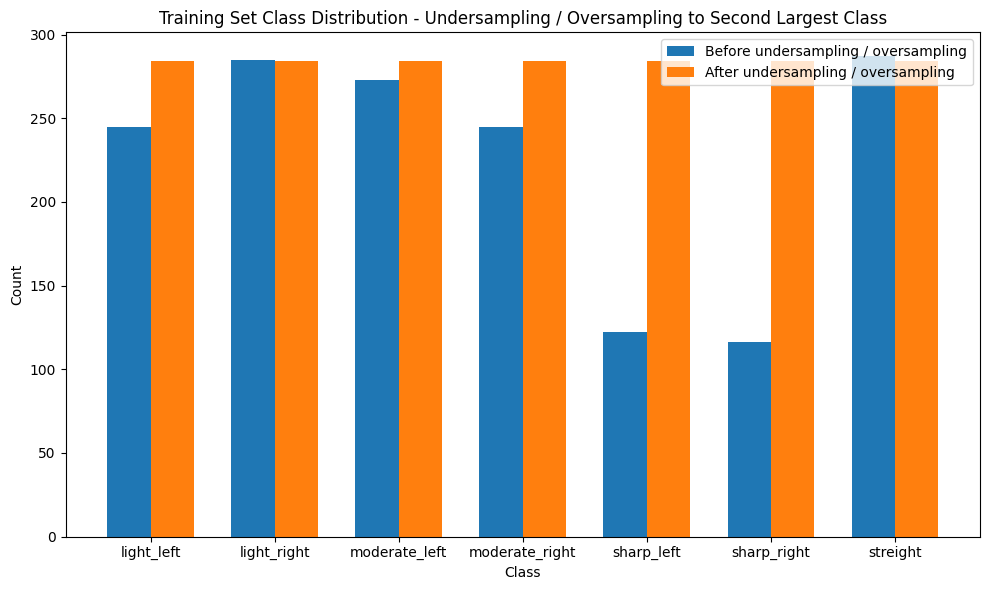

In [14]:
# compare class counts before and after
print("Before undersampling / oversampling:", Counter(y_train))
print("After undersampling / oversampling:", Counter(y_res))
before_counts = [count_class_size(c) for c in labels]
after = Counter(y_res)
after_counts = [after[c] for c in range(len(labels))]

plt.figure(figsize=(10, 6))
plt.title('Training Set Class Distribution - Undersampling / Oversampling to Second Largest Class')
x = np.arange(len(labels))
width = 0.35
# draw bars offset to the left and right
plt.bar(x - width/2, before_counts, width, label='Before undersampling / oversampling')
plt.bar(x + width/2, after_counts,  width, label='After undersampling / oversampling')

# add some labels
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(x, labels)             # put the class names on the x-axis
plt.legend()

plt.tight_layout()
plt.show()

  Preparing metadata (setup.py) ... done
(32, 10, 224, 224, 3)
(32,) tf.Tensor([3 1 0 3 2 0 1 3 1 2 0 0 2 2 1 0 1 2 0 0 1 3 3 1 0 3 2 2 0 1 1 3], shape=(32,), dtype=int16)



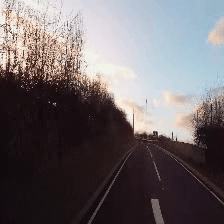

In [15]:
# Display example gif - code from https://www.tensorflow.org/tutorials/load_data/video
!pip install -q git+https://github.com/tensorflow/docs

import imageio
from tensorflow_docs.vis import embed

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  if CHANNELS == 2:
    # convert back to RGB by adding zero channel
    converted_images = np.concatenate([converted_images, np.zeros_like(converted_images[..., :1])], axis=-1)
  imageio.mimsave('./animation.gif', converted_images, fps=1)
  return embed.embed_file('./animation.gif')

frames, label = next(iter(train_ds))
print(frames.shape)
print(label.shape, label)
to_gif(frames[7])

## Create the model

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters.

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [16]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [17]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [18]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [19]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [20]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [21]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [22]:
# Number of classes
num_classes = len(labels)

input_shape = (None, 10, HEIGHT, WIDTH, CHANNELS)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(num_classes)(x)

model = keras.Model(input, x)

In [23]:
frames, label = next(iter(train_ds))
model.build(frames)

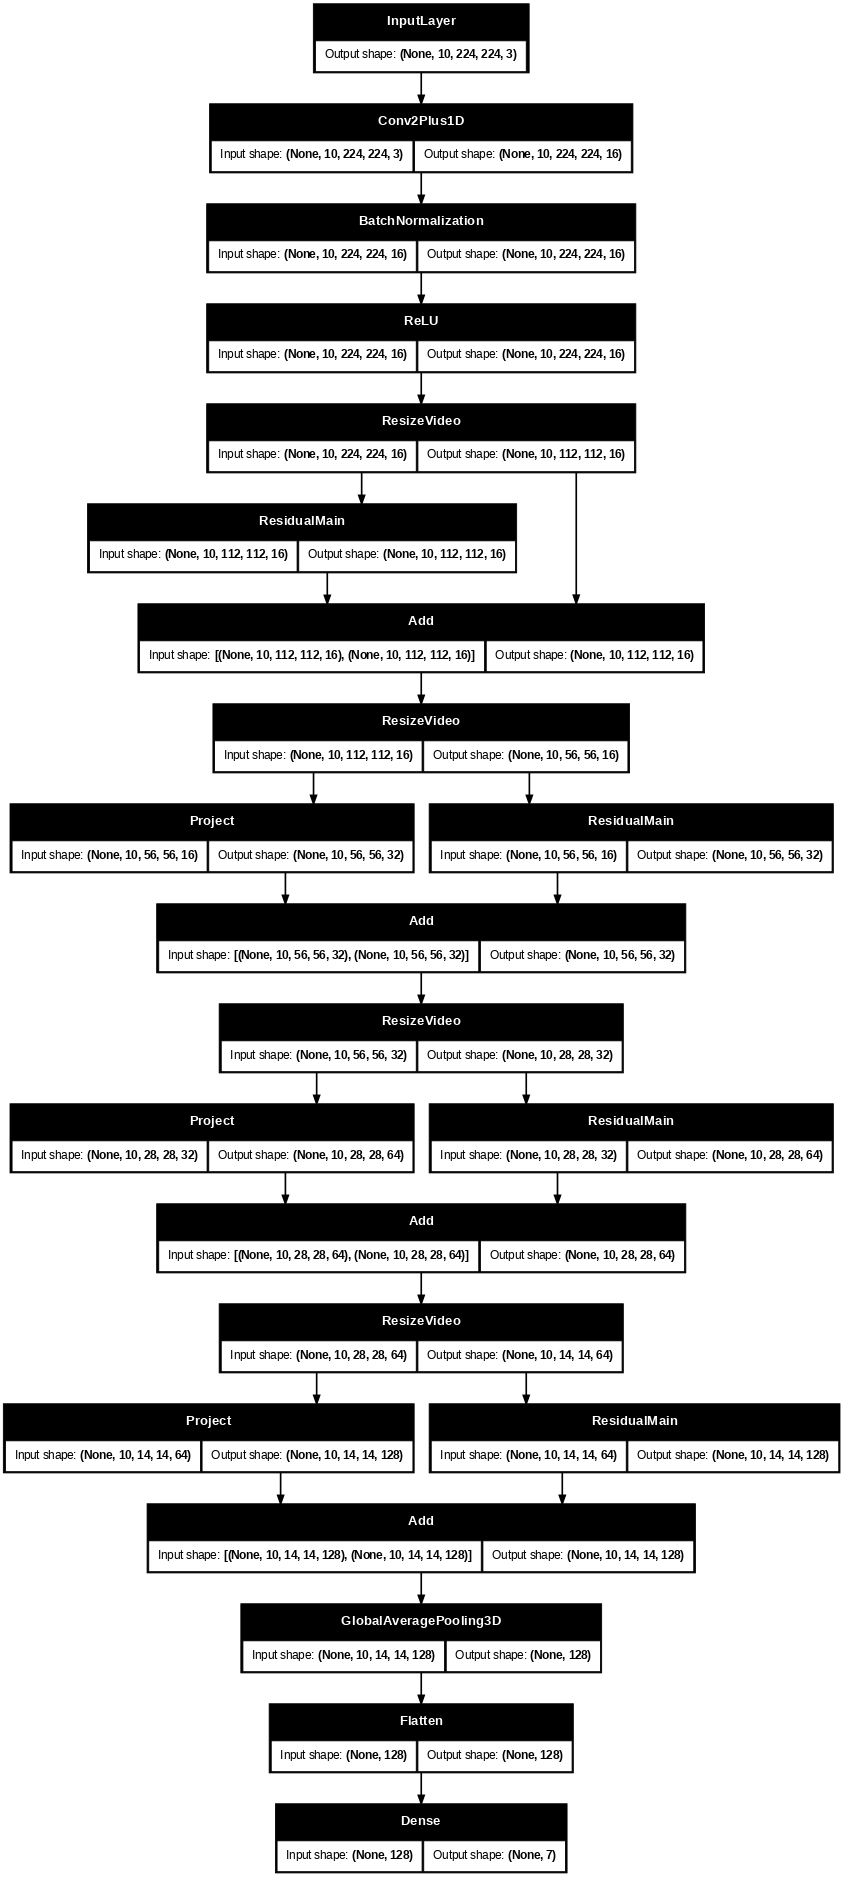

In [24]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [25]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              metrics = [
                  'accuracy'
                  ])

In [26]:
checkpoint_filepath = '/models/bend_classification.keras'
os.makedirs(os.path.dirname(checkpoint_filepath), exist_ok=True)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',                 # Metric to monitor
    verbose=1,                          # Verbosity mode
    save_best_only=True,                # Save only the best model
    save_weights_only=False,            # Save the entire model (architecture + weights)
    mode='auto',                        # Mode for monitoring the metric
    save_freq='epoch'                   # Save frequency
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1
)

training_dataset_size = get_dataset_size('train')

history = model.fit(x = train_ds,
                    epochs = 300,
                    validation_data = val_ds,
                    steps_per_epoch = training_dataset_size // batch_size,
                    callbacks=[reduce_lr, early_stopping] #checkpoint_callback
                    )

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 94s 951ms/step - accuracy: 0.1760 - loss: 2.8014 - val_accuracy: 0.0780 - val_loss: 2.1774 - learning_rate: 0.0010
Epoch 2/300


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.1985 - loss: 2.0106 - val_accuracy: 0.0735 - val_loss: 2.0882 - learning_rate: 0.0010
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 866ms/step - accuracy: 0.1939 - loss: 1.9908 - val_accuracy: 0.2004 - val_loss: 2.0477 - learning_rate: 0.0010
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 862ms/step - accuracy: 0.1819 - loss: 1.9870 - val_accuracy: 0.1559 - val_loss: 2.0982 - learning_rate: 0.0010
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 867ms/step - accuracy: 0.2401 - loss: 1.9303 - val_accuracy: 0.1871 - val_loss: 1.9680 - learning_rate: 0.0010
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 857ms/step - accuracy: 0.2398 - loss: 1.9273 - val_accuracy: 0.0780 - val_loss: 2.3816 - learning_rate: 0.0010
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 860ms/step - accuracy: 0.2336 - loss: 1.9291 - val_accuracy: 0.1626 - val_loss: 2.0364 - learning_rate: 0.0010
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 863ms/step - accuracy: 0.2409 - loss: 1.9138 - v

### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset.

In [ ]:
model.evaluate(test_ds, return_dict=True)

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

In [ ]:
def get_actual_predicted_labels(dataset):
    print("Getting ground truths")
    actual = tf.concat([labels for _, labels in dataset], axis=0)
    print("Getting predictions")
    preds_proba = model.predict(dataset)
    predicted = tf.argmax(preds_proba, axis=1)
    return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of bend classification for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
def plot_learning_rate(history):
  fig, (ax1) = plt.subplots(1)

  fig.set_size_inches(10, 10)

  # Plot loss
  ax1.set_title('Learning Rate')
  ax1.plot(history.history['learning_rate'], label = 'Learning Rate')
  ax1.set_ylabel('Learning Rate')
  ax1.set_xlabel('Epoch')
  ax1.legend(['Learning Rate'])

  plt.show()

plot_learning_rate(history)

In [ ]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

In [ ]:
actual, predicted = get_actual_predicted_labels(val_ds)
plot_confusion_matrix(actual, predicted, labels, 'Validation Set')

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'Test Set')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
recall

In [ ]:
# calculate f1
f1_score = dict()
for key in precision:
  f1_score[key] = 2 * (precision[key] * recall[key]) / (precision[key] + recall[key])

f1_score

# Save Model

In [ ]:
model.save('bend_classification.keras')